# Project 2:  Lucid Titanic Sleuthing

## Part 1: Developing an understanding of the data

#### Based on the description of the data you read in the readme describe in your own words this data.

This data describes the passengers of both the Titanic and Lusitania ships, when they sunk. This includes family information, fare, passenger class and more. 

#### Based on our conceptual understanding of the columns in this data set.  What are the reasonable range of the values for the Sex, Age, SibSp, Parch columns.

Sex could either be male or female, age could be from newborn (0) to 120 years (that is high, but inclusive). SibSp could be anywhere from 0 to 10 (which would be very high), and parrents and children could be from 0 to 10. 

### Open the data in sublime text is there anything that jumps out to you?

There are many more columns in the Lusitania file, however there is much missing data from both Lusitania and Titanic data sets. Furthermore, there is much of the same information in both files, however, they describe them differently in each data set. For exmaple, the survived column(1 for saved, 0 for not) in the Titanic refers to the fate column ('Saved' for saved, 'Lost' for not) in Lusitania. While these data sets are compatable for comparison, some data cleanup is necessary. 

## Part 2: reading the data in

#### Now read the data into a Pandas DataFrame

In [101]:
import pandas as pd
import numpy as np
titanic_file = "/Users/Scott/dsi/DSI_Workspace/project-02/assets/titanic.csv"
lusitania_file = "/Users/Scott/dsi/DSI_Workspace/project-02/assets/lusitania.csv"
titanic = pd.read_csv(titanic_file)
lusitania = pd.read_csv(lusitania_file)


#### Check that the age column doesn't have any unreasonable values 

In [102]:
titanic_age_set = set(titanic['age'])
t_age_count = 0
for value in titanic['age']:
    try:
        int(value)
    except:
        t_age_count += 1
t_age_count

263

In [103]:
lustitania_age_set = set(lusitania['Age'])
l_age_count = 0
for value in lusitania['Age']:
    try:
        int(value)
    except:
        l_age_count += 1
l_age_count

731

There are many NaNs (missing ages) and a few guessed ages, represented by '(age) ?'. Any value where int(value) does not work should be considered unreasonable.

#### Check for missing values.  How do you know that a value is missing?

Missing values are represented by NaNs, which there are many in both data sets. The '(age) ?' should not be counted as a missing data as the person recording it should have some reasonable insight as to why they made that guess. Thus, '(age) ?' will be converted to age.

#### Does it makes sense to guess at the value?

I am conflicted on this issue. I think you can guess at the value if you can figure out some sort of relationship between that value and other values, you can interpolate the missing value from those other values. However, this should be done in a systematic way, accepting that there will be some error in the results. However, I would only do this in order to create a usable data set, if results aren't much differnt without any data interpolation I would error on the side of just removing those columns to preserve scientific uncertainty. 

Reasonable guesses should also be disclosed.

## Part 3: data imputation

In [104]:
#cleaning notes

#droping all crew members from lustitania because titanic only has passenger data. also dropping stoways because they
#do not have the same rights as passengers
lusitania = lusitania.loc[lusitania['Passenger/Crew'] != 'Crew']
lusitania = lusitania.loc[lusitania['Passenger/Crew']!= 'Stowaway']

#testing
titanic.survived.loc[titanic.survived == 1] = 'Saved'
titanic.survived.loc[titanic.survived !='Saved'] = "Died"


#lusitania and titanic survial status to same scale
#lusitania['Fate'].loc[lusitania.Fate == 'Saved'] = 1 
lusitania['Fate'].loc[lusitania.Fate != 'Saved'] = 'Died'

#lusitania and titanic class to same scale
lusitania['Department/Class'].loc['Saloon' == lusitania['Department/Class']] = 1
lusitania['Department/Class'].loc['Second'== lusitania['Department/Class']] = 2
lusitania['Department/Class'].loc[lusitania['Department/Class'] == 'Third'] = 3
lusitania['Department/Class'].loc['Third (Distressed British Seaman)'== lusitania['Department/Class']] = 3
print set(lusitania['Department/Class'])
print set(titanic['pclass'])


set([1, 2, 3])
set([1, 2, 3])


Because almost all the titanic data is on passengers, I dropped all non passengers from lusitania. I converted all statuses to "Saved" and "Died", or also "1 and 0" respectively if needed for quantative methods. I also put the lusitania class and titanic class on the same scale. The primary factors I will be looking at will be Age, Class, Survival, and Gender. 

#### Well let’s say that it does... You likely noticed that Age has some missing values. How many are missing?

For Titanic, you had 263 missing values in the Age column. For Lusitania, you had 233 missing values in the Age column.  See code in part 2 for the calculation.

#### For the Age of the passangers ... how would you guess at the missing values using the other data present in the CSV.

For the missing age data in the Titanic Data, I will just apply the average of all known ages to unknown values. This will preserve the uncertainty in the data while making it useable. 

In [105]:
# YOU MUST RUN ALL CELLS TO GET THIS BLOCK OF CODE TO WORK, OR ELSE YOU WILL GET A TYPE ERROR!!!!!!
#cleaning ages
t_age_mean = titanic['age'].mean()
titanic.age.loc[pd.isnull(titanic.age)] = t_age_mean

#cleaning lusitania age. For some reason, this doesn't work in 1 for loop, so I have to do multiple.
for value in set(lusitania.Age):
    try:
        if 'm' in value:
            temp = value.split('-')
            temp = float(temp[0])/12
            lusitania.Age.loc[lusitania.Age == value] = temp
    except:
        pass

for value in set(lusitania.Age):
    try:
        if '?' in value:
            temp = value.split(' ')
            if temp[0] == '?':
                lusitania.Age.loc[lusitania.Age == value] = np.nan
            else:
                temp = temp[0].split('?')
                temp = float(temp[0])
                lusitania.Age.loc[lusitania.Age == value] = temp
    except:
        pass

for value in set(lusitania.Age):
    try:
        if 'or' in value:
            temp = value.split(' ')
            temp = float(temp[0])/12
            lusitania.Age.loc[lusitania.Age == value] = temp
    except:
        pass

#final values can be hand assigned
lusitania.Age.loc[lusitania.Age == 'Infant'] = 7.0/12
lusitania.Age.loc[lusitania.Age == '2_'] = 2.0
lusitania.Age = pd.to_numeric(lusitania.Age, errors='coerce')

l_age_mean = lusitania['Age'].mean()
lusitania.Age.loc[pd.isnull(lusitania.Age)] = l_age_mean

#build new data frame with clean data.
titanic_clean = pd.DataFrame([titanic.pclass,titanic.age,titanic.sex,titanic.survived])
titanic_clean = titanic_clean.T
lusitania_clean = pd.DataFrame([lusitania['Department/Class'],lusitania.Age,lusitania.Sex,lusitania.Fate])
lusitania_clean = lusitania_clean.T

#add numerical data for Fate and Sex
sex_change_t = lambda x: 1 if x == 'male' else 0
titanic_clean['n_sex'] = titanic_clean.sex.apply(sex_change_t)
survive_change_t = lambda x: 1 if x == 'Saved' else 0
titanic_clean['n_saved'] = titanic_clean.survived.apply(survive_change_t)
sex_change_l = lambda x: 1 if x == 'Male' else 0
lusitania_clean['n_sex'] = lusitania_clean.Sex.apply(sex_change_l)
lusitania_clean['n_saved'] = lusitania_clean.Fate.apply(survive_change_t)

In [106]:
lusitania_clean.head()

,Department/Class,Age,Sex,Fate,n_sex,n_saved
387,1,19,Male,Saved,1,1
388,1,46,Male,Died,1,0
389,1,58,Male,Died,1,0
390,1,46,Female,Saved,0,1
391,1,42,Female,Saved,0,1


The lusitania data required more decisions and cleaning. First, the strings with "(age)-months" were converted into their year value (first for loop). The second loop converts the "(age)?"  to age.  The third and final loop converts values "age" or "age2" to the first age. No Idea which was better, but their values werent too far off from eachother so I selected the first one.  Finally, since infants are between 2 and 12 months old generally, I assigned them to 7 months old. the "2_" was assigned the age 2. Finally, all the NaNs were assigned to the mean age of all the non NaN ages, just like the titanic data. 

This stage was purposfully done without regex to prove that it was not needed for this project. However, it would have probably been easier! 

## Part 4: Group Statistics

#### Are there any groups that were especially adversely affected in the Titanic wreck? (justify your response numerically)

In [107]:
T_S= titanic_clean.pivot_table(values = 'n_saved',columns = 'sex',aggfunc=sum)
T_C_S = titanic_clean.pivot_table(values = 'n_saved',columns = 'pclass',index='sex',aggfunc=sum)
T_Class = titanic_clean.pivot_table(values = 'n_saved',columns='pclass',aggfunc=sum)

In [108]:
T_Class

pclass
1    200
2    119
3    181
Name: n_saved, dtype: int64

In [109]:
from scipy import stats
print stats.chisquare(T_C_S) # men vs women, survival
print stats.chisquare(T_S) #survival of men,women binned by classes
print stats.chisquare(T_Class)#survival of classes



Power_divergenceResult(statistic=array([ 30.42      ,  40.00840336,   5.30939227]), pvalue=array([  3.47922486e-08,   2.52872653e-10,   2.12107541e-02]))
Power_divergenceResult(statistic=63.368000000000002, pvalue=1.7148122766984472e-15)
Power_divergenceResult(statistic=21.532000000000004, pvalue=2.1105012214096178e-05)


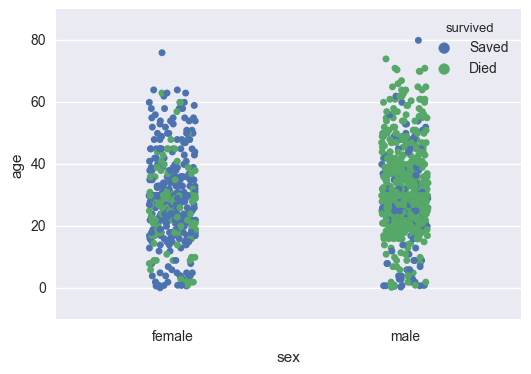

In [110]:
import seaborn as sns
%matplotlib inline
sns.stripplot(x = 'sex',y ='age',hue = 'survived', data =titanic_clean,jitter =True)

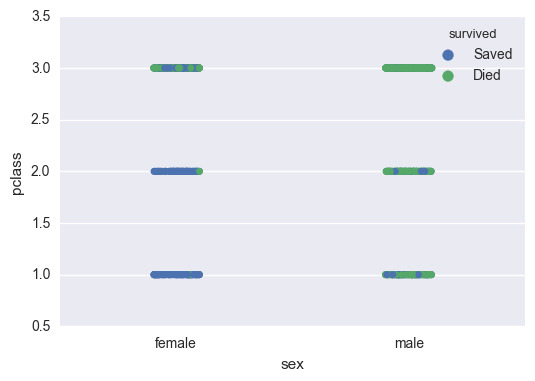

In [111]:
sns.stripplot(x= 'sex',y='pclass',hue='survived',data = titanic_clean,jitter=True)

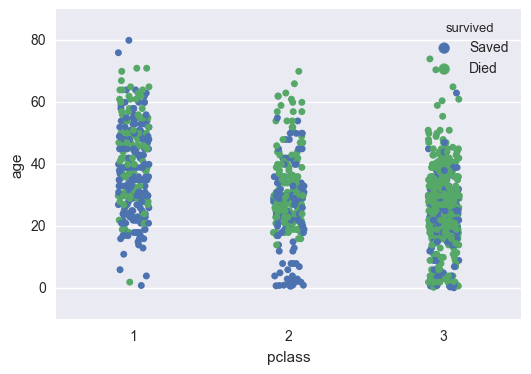

In [112]:
sns.stripplot(x='pclass',y='age',hue='survived',data=titanic_clean,jitter=True)

Men, across the board, were more likely to die than women. This is seen through chi squared test, which gives a signifance value at 1.7148122766984472e-15. This is also supported by the first plot (sex v age). Women had a significantly higher rate of survival no matter age.

When binning men and women by class, men fared worse than women in all classes, supported by chi squared pvalues of 3.47922486e-08,   2.52872653e-10,   2.12107541e-02 (1st, 2nd and 3rd classes respectively). This is also easy seen in the second plot (sex v pclass).

Finally, passengers in 3rd class fared the worst, supported by a chi squared pvalue of 2.1105012214096178e-05. This is also easily seen in the third plot.

#### Are there any groups that outperformed the survival of the latter group? (justify your response numerically)


We can use the same data from the underperformed justifications for the groups that outperformed. Women, across the board, were more likely to live then men. This is seen through chi squared test, which gives a signifance value at 1.7148122766984472e-15. This is also supported by the first plot (sex v age).

When binning men and women by class, women fared better than men in all classes, supported by chi squared pvalues of 3.47922486e-08, 2.52872653e-10, 2.12107541e-02 (1st, 2nd and 3rd classes respectively). This is also easy seen in the second plot (sex v pclass).

Finally, passengers in 1st class fared the best, as seen in the third plot.

## Part 5:  Comparative Statistics:  Lusitania

#### Are there any groups that were especially adversely affected in the Lusitania wreck? (justify your response numerically)

In [113]:
L_S= lusitania_clean.pivot_table(values = 'n_saved',columns = 'Sex',aggfunc=sum)
L_C_S = lusitania_clean.pivot_table(values = 'n_saved',columns = 'Department/Class',index='Sex',aggfunc=sum)
L_Class = lusitania_clean.pivot_table(values = 'n_saved',columns='Department/Class',aggfunc=sum)
print stats.chisquare(L_S)
print stats.chisquare(L_C_S)
print stats.chisquare(L_Class)

Power_divergenceResult(statistic=25.118393234672304, pvalue=5.3916131754493021e-07)
Power_divergenceResult(statistic=array([ 17.28571429,   0.53303965,  21.76119403]), pvalue=array([  3.21595556e-05,   4.65331725e-01,   3.08782927e-06]))
Power_divergenceResult(statistic=47.268498942917553, pvalue=5.4422172006203756e-11)


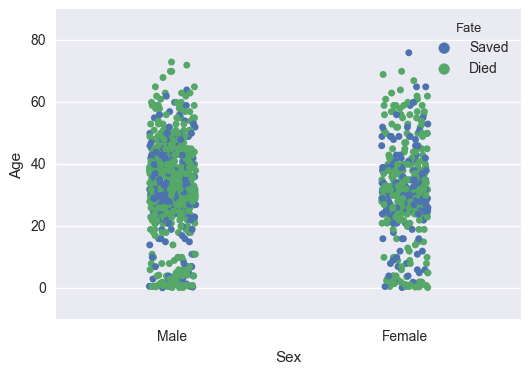

In [114]:
sns.stripplot(x = 'Sex',y ='Age',hue = 'Fate', data =lusitania_clean,jitter =True)

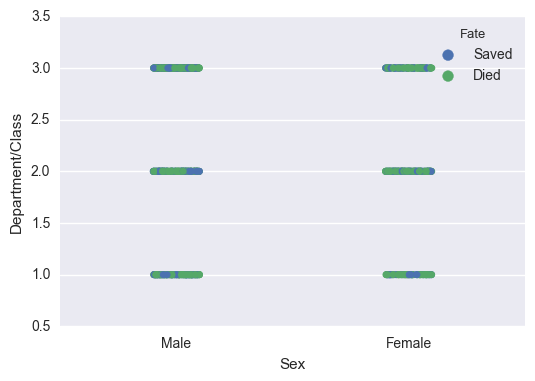

In [115]:
sns.stripplot(x= 'Sex',y='Department/Class',hue='Fate',data = lusitania_clean,jitter=True)

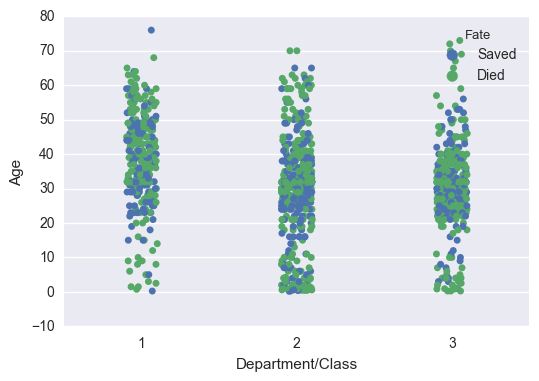

In [116]:
sns.stripplot(x='Department/Class',y='Age',hue='Fate',data=lusitania_clean,jitter=True)

Again, just like the titanic, men died more than women, supported by a pvalue of 5.3916131754493021e-07 from a Chi squared test. However, what the Chi squared test does not capture (but the first plot in this section does) is that the survival distrobution is more even than the Titanic comparison. 

When binning men and women by class, men fared worse than women in all classes, supported by chi squared pvalues of 3.21595556e-05,4.65331725e-01,3.08782927e-06 respectively. However, again this distrobution (seen in the second plot) seems more uniform than the Titanic.

Finally, passengers in 3rd class fared the worst, supported by a chi squared pvalue of 5.4422172006203756e-11. However, same trend as the previous chi squared comparisons, the distrobution seems more even than the Titanic (seen in third plot).

#### Are there any groups that outperformed the survival of the latter group? (justify your response numerically)



We can use the same tests to say the inverse, women outperformed men supported by a pvalue of 5.3916131754493021e-07.

When binning men and women by class, women fared worse than men in all classes, supported by chi squared pvalues of 3.21595556e-05,4.65331725e-01,3.08782927e-06 respectively.

Finally, passengers in 1st class fared the best, supported by a chi squared pvalue of 5.4422172006203756e-11.


#### What does the group-wise survival rate imply about circumstances during these two accidents?

In [119]:
from __future__ import division
L_survival_rate = (float(sum(lusitania_clean.n_saved))/len(lusitania_clean.n_saved))*100
T_survival_rate = float((sum(titanic_clean.n_saved ))/len(titanic_clean.n_saved) *100)
print L_survival_rate, T_survival_rate


37.3913043478 38.1970970206


The numbers make intuative sense, Women(especially in 1st class) generally fared the best of any demographics.However, the overall distrobution of people who died on the titanic when compared to the lusitania really reveals what a tragedy the titanic was. The titanic took ~3 hours to sink and had a similar survival rate to the lusitania, which sank in ~20 minutes, roughly 9 times faster than the titanic! The largest reason so many people died on the titanic, historically, is that they did not have close to enough lifeboats to support the entire population on board. This is why the famous vernacular "women and children first" can provide great insight into why men took a significantly bigger hit on the titanic. While the titanic should have never sunk (man error), many people died because the ship was not prepared properly
   
Women also fared better on the lusitania, hower, the more uniform distrobution of the data (see plots) exemplify the rapid nature of its sinking. 20 minutes is not a long time to evacuate the passengers on board. People died because it was a fast event. 

Overall the data is consistent with historical stories told about these two sinking ships. 
    